# Task 1 Mitbih Data (VanillaCNN,VanillaRNN)

## Loading modules
Note we load models, data and plotting function from models.ipynb and helper_functions.ipynb

In [1]:
import itertools

In [2]:
import io
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import tensorflow as tf
from keras import losses
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from pathlib import Path
from scipy import stats
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
%load_ext tensorboard
# For evaluation

## Load needed functions

### Models

In [4]:
# Similar model to base line, added BatchNorm, adjusted kernel_sizes, filter_sizes and pooling layers
def CNN(nclass, time_steps, features, af):
    inputs = keras.layers.Input([187,1])
    x = keras.layers.Conv1D(filters=16, kernel_size=3, strides=1)(inputs)
    x = keras.layers.Conv1D(filters=16, kernel_size=9, strides=1)(x)

    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Conv1D(filters=256, kernel_size=5, strides=1)(x)
    x=keras.layers.Conv1D(filters=92, kernel_size=9, strides=1)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Conv1D(filters=184, kernel_size=9, strides=1)(x)
    x=keras.layers.Conv1D(filters=104, kernel_size=3, strides=1)(x)
    x=keras.layers.BatchNormalization()(x)
    x=keras.layers.ReLU()(x)
    x=keras.layers.MaxPool1D(pool_size=5, strides=1)(x)

    x=keras.layers.Flatten()(x)
    x=keras.layers.Dense(1924, activation="relu")(x)
    outputs=keras.layers.Dense(nclass,activation=af)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model


def RNN(nclass, time_steps, features, af):
    model = keras.Sequential([
        keras.layers.LSTM(16, return_sequences=True,
                          input_shape=(time_steps, features)),
        keras.layers.Dropout(0.5),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.LSTM(64, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.BatchNormalization(),
        keras.layers.Flatten(),
        keras.layers.Dense(512, activation="relu"),
        keras.layers.Dense(nclass, activation=af)
    ])
    model.summary()
    return model

### Helper functions

In [5]:
def get_model(data, model_name):
    time_steps = 187
    features = 1
    if data == "mitbih":
        number_class = 5
        activation_function = "softmax"
        loss = losses.sparse_categorical_crossentropy
    elif data == "ptbdb":
        number_class = 1
        activation_function = "sigmoid"
        loss = losses.binary_crossentropy
    if model_name == "ResNet":
        np.expand_dims(X_train, -1)
        np.expand_dims(Y_train, -1)
        model = ResNet(number_class, time_steps, features, activation_function)
    elif model_name == "CNN":
        model = CNN(number_class, time_steps, features, activation_function)
    elif model_name == "CNNDML":
        model = CNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "RNN":
        model = RNN(number_class, time_steps, features, activation_function)
    elif model_name == "RNNDML":
        model = RNNDML(number_class, time_steps, features, activation_function)
    elif model_name == "BaseLine":
        model = BaseLine(number_class, time_steps,
                         features, activation_function)

    elif model_name == "Transformer":
        model = Transformer(number_class, time_steps,
                            features, activation_function)
    elif model_name == "LSTM_FCN":
        model = LSTM_FCN(number_class, time_steps,
                         features, activation_function)
    elif model_name == "Encoder":
        model = Encoder(number_class, time_steps,
                        features, activation_function)
    elif model_name == "EncoderDML":
        model = EncoderDML(number_class, time_steps,
                           features, activation_function)
    elif model_name == "RNNAdvanced":
        model = RNNAdvanced(number_class, time_steps,
                            features, activation_function)
    elif model_name == "CNN2":
        model = CNN2(number_class, time_steps, features, activation_function)
    return model, loss


def get_data(data, data_path, zscore=True):
    if data == "mitbih":
        df_train = pd.read_csv(data_path+"/mitbih_train.csv", header=None)
        df_train = df_train.sample(frac=1)
        df_test = pd.read_csv(data_path+"/mitbih_test.csv", header=None)

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    elif data == "ptbdb":
        df_1 = pd.read_csv(data_path+"/ptbdb_normal.csv", header=None)
        df_2 = pd.read_csv(data_path+"/ptbdb_abnormal.csv", header=None)
        df = pd.concat([df_1, df_2])

        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1337, stratify=df[187])

        Y = np.array(df_train[187].values).astype(np.int8)
        X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

        Y_test = np.array(df_test[187].values).astype(np.int8)
        X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

    if zscore:
        X = stats.zscore(X, axis=1)
        X_test = stats.zscore(X_test, axis=1)

    return X, X_test, Y, Y_test


def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred = model.predict(X_test)
    test_pred = np.argmax(test_pred, axis=-1)
    classes = [*mitbih_dict]
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = True
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(model_name+" Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)


def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def plot_model_results(model, history, model_path, data, model_name, X_test, Y_test):
    model.load_weights(model_path)
    if model_name == "ResNet":
        X_test = np.expand_dims(X_test, -1)
        Y_test = np.expand_dims(Y_test, -1)
        model.evaluate(X_test, Y_test)
    if data == "mitbih":
        mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}
        pred_test = model.predict(X_test)
        pred_test = np.argmax(pred_test, axis=-1)

        pd.DataFrame(history.history).plot(figsize=(8, 5))

        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)

        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))

        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*mitbih_dict],
            normalize=True,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
    elif data == "ptbdb":
        ptbdb_dict = {'Normal': 0, 'Abnormal': 1}
        pred_test = model.predict(X_test)
        pred_test = (pred_test > 0.5).astype(np.int8)
        f1 = f1_score(Y_test, pred_test, average="macro")
        acc = accuracy_score(Y_test, pred_test)
        print("Test F1 score : {:.4f}".format(np.mean(f1)))
        print("Test ACC score : {:.4f}".format(np.mean(acc)))
        plot_confusion_matrix(
            Y_test,
            pred_test,
            [*ptbdb_dict],
            normalize=False,
            title="Confusion matrix",
            cmap=plt.cm.Blues)
        plot_roc(Y_test, pred_test)
        plot_precisionrecall(Y_test, pred_test)

#### Define path, where data is stored and where you want the models and results stored!

In [6]:
working_path = pathlib.Path().resolve()
path_object = Path(working_path)
parent_path = path_object.parent
model_path_parent = os.path.join(parent_path, "03-Models/02-Mitbih/01-Task1")
data_path = os.path.join(parent_path, "01-Data")
tensorboard_path_parent = os.path.join(
    parent_path, "04-Logs/02-Mitbih/01-Task1")

## VanillaCNN
### Compile and run

In [7]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "mitbih"
model_name = "CNN"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}

# Define Hyperparameters
epochs = 150
learning_rate = 0.0005
batch_size = 64
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 185, 16)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 177, 16)           2320      
                                                                 
 batch_normalization (BatchN  (None, 177, 16)          64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 177, 16)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 173, 16)          0         
 )                                                           

In [8]:
# Compile and Run
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/150
1232/1232 [==============================] - ETA: 0s - loss: 0.2532 - accuracy: 0.9449
Epoch 1: val_accuracy improved from -inf to 0.96345, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\CNN_mitbih_weights.h5
1232/1232 [==============================] - 38s 26ms/step - loss: 0.2532 - accuracy: 0.9449 - val_loss: 0.1357 - val_accuracy: 0.9635 - lr: 5.0000e-04
Epoch 2/150
1230/1232 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.9697
Epoch 2: val_accuracy improved from 0.96345 to 0.97510, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\CNN_mitbih_weights.h5
1232/1232 [==============================] - 31s 25ms/step - loss: 0.1066 - accuracy: 0.9698 - val_loss: 0.0931 - val_accuracy: 0.9751 - lr: 5.0000e-04
Epoch 3/150
1232/1232 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9753
Epoch 3: val_accuracy improved from 0.97510 to 0

1232/1232 [==============================] - 30s 25ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0590 - val_accuracy: 0.9889 - lr: 5.0000e-05
Epoch 23/150
1230/1232 [============================>.] - ETA: 0s - loss: 0.0041 - accuracy: 0.9985
Epoch 23: val_accuracy did not improve from 0.98892
1232/1232 [==============================] - 30s 24ms/step - loss: 0.0041 - accuracy: 0.9985 - val_loss: 0.0609 - val_accuracy: 0.9887 - lr: 5.0000e-05
Epoch 24/150
1231/1232 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.9987
Epoch 24: val_accuracy did not improve from 0.98892
1232/1232 [==============================] - 30s 24ms/step - loss: 0.0037 - accuracy: 0.9987 - val_loss: 0.0619 - val_accuracy: 0.9879 - lr: 5.0000e-05
Epoch 25/150
1232/1232 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9989
Epoch 25: val_accuracy did not improve from 0.98892

Epoch 25: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
1232/1232 

### Results CNN

Test F1 score : 0.9275
Test ACC score : 0.9870
Normalized confusion matrix
[[9.96302020e-01 1.82139309e-03 1.10387460e-03 4.96743570e-04
  2.75968650e-04]
 [1.72661871e-01 8.03956835e-01 1.43884892e-02 5.39568345e-03
  3.59712230e-03]
 [2.96961326e-02 2.07182320e-03 9.55801105e-01 9.66850829e-03
  2.76243094e-03]
 [1.04938272e-01 0.00000000e+00 7.40740741e-02 8.20987654e-01
  0.00000000e+00]
 [9.32835821e-03 0.00000000e+00 6.21890547e-04 0.00000000e+00
  9.90049751e-01]]


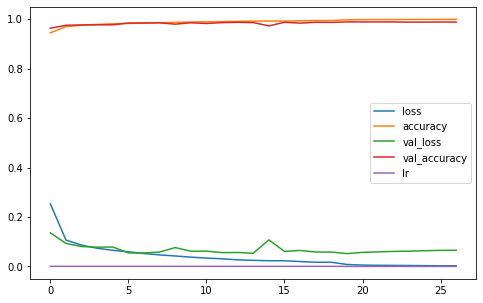

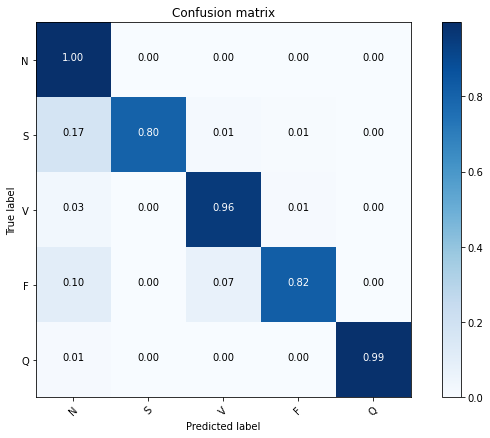

In [9]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [10]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\CNN_mitbih\assets


## VanillaRNN
### Compile and run

In [11]:
# Always clear as keras backend is tedious
tf.keras.backend.clear_session()

# Load the prefered Model and data which will be feeded
data = "mitbih"
model_name = "RNN"
model, loss = get_model(data, model_name)

# will be z-Scored
X_train, X_test, Y_train, Y_test = get_data(data, data_path, zscore=True)
mitbih_dict = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}

# Define Hyperparameters
epochs = 40
learning_rate = 0.0005
batch_size = 64
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = loss


# Define Callbacks (taken from baseline file)
model_path = os.path.join(model_path_parent, model_name+"_"+data+"_weights.h5")
tensorboard_path = os.path.join(tensorboard_path_parent, model_name+"_"+data)
file_writer = tf.summary.create_file_writer(tensorboard_path)


checkpoint = ModelCheckpoint(
    model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy",
                      mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(
    monitor="val_accuracy", mode="max", patience=3, verbose=2)
# uncomment if you want to track in tensorboard
tbc = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path)
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks_list = [
    checkpoint,
    early,
    redonplat,
    tbc,
    cm_callback,
]

# delete tensorboard folder if already exists, so no overlap
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 187, 16)           1152      
                                                                 
 dropout (Dropout)           (None, 187, 16)           0         
                                                                 
 batch_normalization (BatchN  (None, 187, 16)          64        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 187, 32)           6272      
                                                                 
 dropout_1 (Dropout)         (None, 187, 32)           0         
                                                                 
 batch_normalization_1 (Batc  (None, 187, 32)          128       
 hNormalization)                                        

In [12]:
# Compile and Run
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epochs,
                    shuffle=True, batch_size=batch_size, callbacks=callbacks_list)

Epoch 1/40
1232/1232 [==============================] - ETA: 0s - loss: 0.2169 - accuracy: 0.9459
Epoch 1: val_accuracy improved from -inf to 0.96882, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\RNN_mitbih_weights.h5
1232/1232 [==============================] - 73s 56ms/step - loss: 0.2169 - accuracy: 0.9459 - val_loss: 0.1038 - val_accuracy: 0.9688 - lr: 5.0000e-04
Epoch 2/40
1231/1232 [============================>.] - ETA: 0s - loss: 0.1043 - accuracy: 0.9707
Epoch 2: val_accuracy improved from 0.96882 to 0.97613, saving model to C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\RNN_mitbih_weights.h5
1232/1232 [==============================] - 67s 55ms/step - loss: 0.1043 - accuracy: 0.9707 - val_loss: 0.0829 - val_accuracy: 0.9761 - lr: 5.0000e-04
Epoch 3/40
1231/1232 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9761
Epoch 3: val_accuracy improved from 0.97613 to 0.98

### Results RNN

Test F1 score : 0.9191
Test ACC score : 0.9860
Normalized confusion matrix
[[9.96026051e-01 2.04216801e-03 1.15906833e-03 3.31162380e-04
  4.41549840e-04]
 [1.88848921e-01 7.98561151e-01 7.19424460e-03 3.59712230e-03
  1.79856115e-03]
 [2.90055249e-02 4.83425414e-03 9.57182320e-01 6.90607735e-03
  2.07182320e-03]
 [1.29629630e-01 0.00000000e+00 1.29629630e-01 7.40740741e-01
  0.00000000e+00]
 [1.05721393e-02 0.00000000e+00 1.24378109e-03 0.00000000e+00
  9.88184080e-01]]


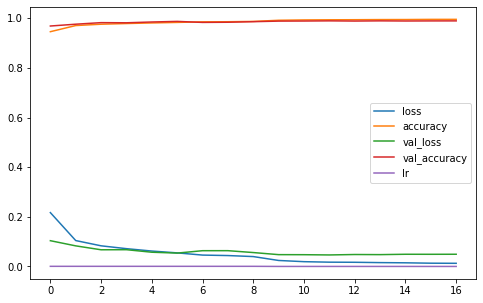

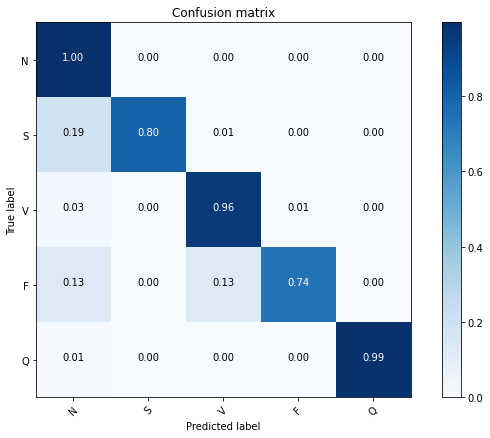

In [13]:
plot_model_results(model, history, model_path,
                   data, model_name, X_test, Y_test)

In [14]:
model_path = os.path.join(model_path_parent, model_name+"_"+data)
model.save(model_path)

INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\RNN_mitbih\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\ML4HC\01-ECG_Classification\Submission\03-Models/02-Mitbih/01-Task1\RNN_mitbih\assets


In [15]:
## Visualizaitons in tensorboard

In [16]:
# Please have a look at in Tensorboard with all needed figures,
# change mode to light on half-moon icon to see labels and move circle above cm to see evolution for each epoch
# You can also look at the results in your browser, see tensorboard documentation

# At parent path, so both Results are compared to each other
%tensorboard --logdir {tensorboard_path_parent.replace(os.sep, '/')}

## Results